In [311]:
import pandas as pd
import os
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

os.chdir("/home/user/michigan/data/Ljosa-BBBC021/database")

In [4]:
GroundTruth = pd.read_csv("supplement_GroundTruth.txt", sep = "\t", names = ["compound","concentration","moa"])

namelist = []
with open("supplement_Image.sql") as f:
    for i in f.readlines():
        if "NULL" in i:
            namelist.append(i.split("`")[1])
#             print(i.split("`")[1])
Image = pd.read_csv("supplement_Image.txt", sep = "\t", names = namelist)

namelist = []
with open("supplement_Object.sql") as f:
    for i in f.readlines():
        if "NULL" in i:
            namelist.append(i.split("`")[1])
Object = pd.read_csv("supplement_Object.txt", sep = "\t", names = namelist)

In [64]:
data = Object.merge(Image[["TableNumber","ImageNumber","Image_Metadata_Compound","Image_Metadata_Concentration"]], on = ["TableNumber", "ImageNumber"])

In [65]:
exclude_features = ['Nuclei_Location_Center_X',
                     'Nuclei_Location_Center_Y',
                     'Cells_Location_Center_X',
                     'Cells_Location_Center_Y',
                     'Cytoplasm_Location_Center_X',
                     'Cytoplasm_Location_Center_Y']
data = data.drop(exclude_features, axis = 1)

In [66]:
treatment_profile = data.groupby(["Image_Metadata_Compound","Image_Metadata_Concentration"], as_index=False).mean()
treatment_profile = treatment_profile[treatment_profile["Image_Metadata_Compound"]!="DMSO"].drop(
    ["TableNumber", "ImageNumber", "ObjectNumber"], axis=1)

In [67]:
treatment_profile

,Image_Metadata_Compound,Image_Metadata_Concentration,Nuclei_Children_Cells_Count,Nuclei_Children_Cytoplasm_Count,Nuclei_AreaShape_Area,Nuclei_AreaShape_Eccentricity,Nuclei_AreaShape_Solidity,Nuclei_AreaShape_Extent,Nuclei_AreaShape_EulerNumber,Nuclei_AreaShape_Perimeter,...,Cytoplasm_Texture_SumAverage_CorrTub_3,Cytoplasm_Texture_SumVariance_CorrTub_3,Cytoplasm_Texture_SumEntropy_CorrTub_3,Cytoplasm_Texture_Entropy_CorrTub_3,Cytoplasm_Texture_DifferenceVariance_CorrTub_3,Cytoplasm_Texture_DifferenceEntropy_CorrTub_3,Cytoplasm_Texture_InfoMeas1_CorrTub_3,Cytoplasm_Texture_InfoMeas2_CorrTub_3,Cytoplasm_Texture_GaborX_CorrTub_3,Cytoplasm_Texture_GaborY_CorrTub_3
0,ALLN,3.00,1.0,1.0,1157.832074,0.654171,0.948859,0.719233,1.000000,130.944112,...,7.064630,9.188310,2.355262,2.859392,0.482934,0.930165,-0.362391,0.837620,0.678694,0.847872
1,ALLN,100.00,1.0,1.0,1098.804462,0.632541,0.949649,0.719629,0.998688,127.561326,...,6.852484,9.958855,2.322287,2.965824,0.814069,1.130238,-0.289247,0.778443,1.005640,1.180094
2,AZ-A,0.10,1.0,1.0,1350.573203,0.669491,0.920309,0.679048,1.000000,147.405773,...,6.266198,8.144003,2.257828,2.728268,0.418223,0.883181,-0.362623,0.828351,0.613595,0.750765
3,AZ-A,0.30,1.0,1.0,1262.068193,0.684752,0.910968,0.667818,0.998473,143.659532,...,6.426010,8.193388,2.270651,2.753054,0.422327,0.893322,-0.359134,0.826919,0.707752,0.907661
4,AZ-A,1.00,1.0,1.0,1293.170543,0.672960,0.917893,0.677899,0.998708,144.208507,...,6.490543,8.472915,2.287445,2.790886,0.434160,0.908002,-0.351646,0.823023,0.690148,0.842123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,vincristine,0.03,1.0,1.0,1336.797895,0.621604,0.932107,0.705035,1.000000,144.148579,...,6.943551,9.153444,2.255935,2.720640,0.519153,0.942454,-0.376348,0.831852,0.676158,0.770480
100,vincristine,0.10,1.0,1.0,1225.438578,0.621367,0.926624,0.690728,1.000000,139.315983,...,6.635766,9.509208,2.229477,2.695209,0.539822,0.959719,-0.370313,0.825775,0.677932,0.781746
101,vincristine,0.30,1.0,1.0,1327.229075,0.623671,0.927737,0.693233,1.000000,144.682725,...,6.709864,9.496780,2.243526,2.695981,0.500906,0.936535,-0.379896,0.834214,0.630876,0.720837
102,vincristine,1.00,1.0,1.0,1242.112513,0.623933,0.929850,0.694906,1.000000,139.647670,...,6.438216,9.108899,2.201666,2.710628,0.592802,0.988159,-0.342589,0.804144,0.563043,0.687063


In [101]:
X = np.array(treatment_profile.drop("Image_Metadata_Compound", axis=1))
y = np.array(treatment_profile["Image_Metadata_Compound"])



In [141]:
comp_moa = GroundTruth.drop("concentration", axis = 1).drop_duplicates()

,compound,concentration,moa
35,simvastatin,2.0,Cholesterol-lowering
36,simvastatin,20.0,Cholesterol-lowering
87,simvastatin,6.0,Cholesterol-lowering


In [174]:
def get_MOA(comp):
    return comp_moa[comp_moa["compound"]==comp]["moa"].values[0]

In [203]:
get_MOA("ALLN")

'Protein degradation'

In [185]:
X[0:1].shape

(1, 471)

In [217]:
result = pd.DataFrame()
for i in range(len(X)):
    masked_index = y == y[i]
    X_train = X[masked_index == False]
    y_train = y[masked_index == False]
    
    X_test = X[i:(i+1)]

    y_test = y[i]
#     print( X[masked_index == False])
    
    neigh = KNeighborsClassifier(
    n_neighbors=1, algorithm='brute', metric='cosine')
    neigh.fit(X_train, y_train)
    
    pred = neigh.predict(X_test)
#     print(pred[0])

#     print(get_MOA(pred[0]) == get_MOA(y_test), y_test)
    result = result.append({"y":get_MOA(y_test),"y_pred":get_MOA(pred[0])}, ignore_index=True)


In [221]:
result["correct"] = result["y"] == result["y_pred"]
result["correct"].mean()

0.42718446601941745

In [243]:
confu_mat = confusion_matrix(result["y"], result["y_pred"], labels = result["y"].value_counts().sort_index().index)

In [241]:
result["y"].value_counts().sort_index()

Actin disruptors              5
Aurora kinase inhibitors     12
Cholesterol-lowering          6
DNA damage                    9
DNA replication               8
Eg5 inhibitors               12
Epithelial                    8
Kinase inhibitors             5
Microtubule destabilizers    14
Microtubule stabilizers       9
Protein degradation           7
Protein synthesis             8
Name: y, dtype: int64

In [231]:
result["y_pred"].value_counts()

Microtubule destabilizers    19
DNA damage                   12
Microtubule stabilizers      11
Cholesterol-lowering          9
DNA replication               9
Aurora kinase inhibitors      8
Protein synthesis             7
Epithelial                    7
Protein degradation           6
Eg5 inhibitors                6
Kinase inhibitors             5
Actin disruptors              4
Name: y_pred, dtype: int64

In [224]:
for i in result["correct"]:
    print(i)

True
False
False
True
True
True
True
True
False
False
False
False
False
False
False
True
False
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
False
False
True
True
True
True
True
False
True
False
True
True
False
False
True
True
False
False
False
True
True
True
True
False
False
False
False
False
False
False
True
True
False
True
False
False
False
True
False
False
False
True
True
False
True
True
True
False
False
True
False
False
False
False
False
True
True
False
False
False
False
True
True
True
True
True
False


In [320]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


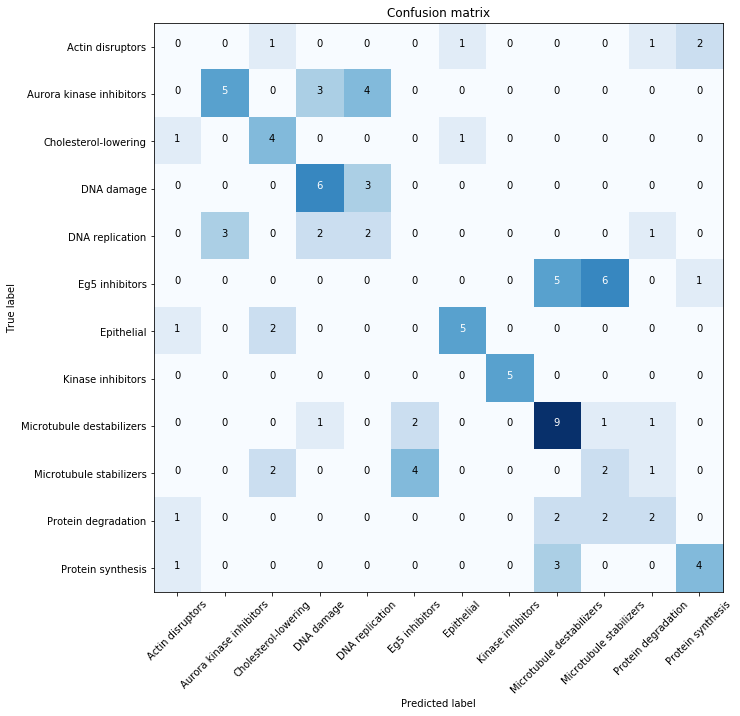

In [319]:
plot_confusion_matrix(confu_mat,classes=result["y"].value_counts().sort_index().index)

In [89]:
similarity = cosine_similarity(X)

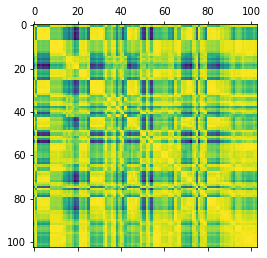

In [90]:
import matplotlib.pyplot as plt
plt.matshow(similarity)